In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from engine import Tensor, draw_dot
import nn

(1000, 2) (1000, 1)


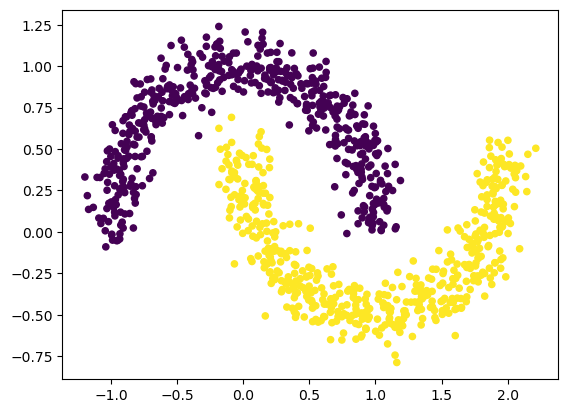

In [3]:
X, y = make_moons(n_samples=1_000, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
y = np.expand_dims(y, 1)
print(X.shape, y.shape)

Label:  data 1455.9260080565127, grad 1.0 op sum


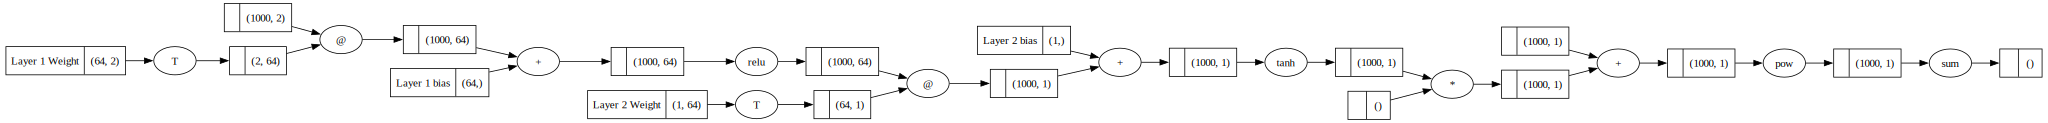

In [9]:

model = nn.Sequential(
    nn.Linear(2, 64, name="Layer 1"),
    # nn.Tanh(),
    nn.ReLU(),
    nn.Linear(64, 1, name="Layer 2"),
    nn.Tanh()
    # nn.ReLU()
)

loss_func = lambda y_true, y_pred: ((y_true - y_pred)**2).sum()
# print(X.shape)
loss = loss_func(Tensor(y), model(Tensor(X)))
loss.backward()
print(loss)
draw_dot(loss)

In [10]:
lr = 0.001
batch_size = 100
alpha = 1e-3

for k in range(100):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    x_batch, y_batch = Tensor(X[ri, :]), Tensor(y[ri, :])
    model.zero_grad()
    y_pred = model(x_batch)
    loss = loss_func(y_batch, y_pred)
    reg = alpha*sum((p*p).sum() for p in model.parameters())
    acc = np.sum((y_pred.data > 0) == (y_batch.data > 0)) / y_batch.shape[0]
    (loss + reg).backward()

    for p in model.parameters():
        # print(p.label, np.linalg.norm(p.grad))
        p.data -= lr*p.grad

    print(f"{k:03} loss: {loss.data}, acc: {acc*100}")

000 loss: 139.62647184772007, acc: 65.0
001 loss: 70.09377161088449, acc: 66.0
002 loss: 39.14607418863427, acc: 87.0
003 loss: 24.971071586779054, acc: 91.0
004 loss: 20.625775231295222, acc: 93.0
005 loss: 16.339023974042135, acc: 93.0
006 loss: 22.741045665876513, acc: 90.0
007 loss: 14.592140822734766, acc: 96.0
008 loss: 26.330569657050734, acc: 89.0
009 loss: 23.536321482095605, acc: 93.0
010 loss: 19.41501171704121, acc: 96.0
011 loss: 19.8113704512678, acc: 96.0
012 loss: 29.062692079491473, acc: 90.0
013 loss: 16.977166345905854, acc: 97.0
014 loss: 16.613185950231014, acc: 95.0
015 loss: 16.955700483820372, acc: 95.0
016 loss: 18.689223470040716, acc: 93.0
017 loss: 20.813779911204556, acc: 92.0
018 loss: 22.493566935389573, acc: 92.0
019 loss: 21.780685382070324, acc: 94.0
020 loss: 16.238111961992136, acc: 98.0
021 loss: 28.976588590598904, acc: 88.0
022 loss: 14.521469601209757, acc: 98.0
023 loss: 15.798880913726665, acc: 95.0
024 loss: 15.187123683421616, acc: 96.0
025 l

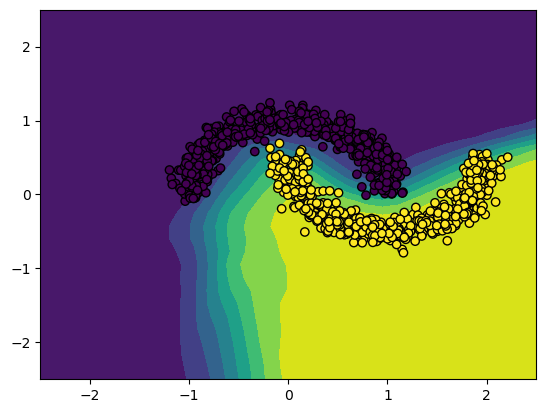

In [11]:
from sklearn.inspection import DecisionBoundaryDisplay

xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 30), np.linspace(-2.5, 2.5, 30))
grid = np.vstack([xx.ravel(), yy.ravel()]).T
grid_tensor = Tensor(grid)
y_pred = model(grid_tensor)

display = DecisionBoundaryDisplay(xx0=xx, xx1=yy, response=np.reshape(y_pred.data, xx.shape))
display.plot()

display.ax_.scatter(
    X[:, 0], X[:, 1], c=y, edgecolor="black"
)

plt.show()